In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

plt.rcParams['axes.grid'] = False

## Train json과 Val json의 annotation label 분포 알아보기
 - category 개수는 당연히 동일

In [2]:
# train.json
dataset_path = '/opt/ml/input/data'
train_anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(train_anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

train_categories = dataset['categories']
train_anns = dataset['annotations']
train_imgs = dataset['images']

# Load categories and super categories
cat_names = []
for cat_it in train_categories:
    cat_names.append(cat_it['name'])

print('Number of train_categories:', len(train_categories))
print('Number of train_annotations:', len(train_anns))
print('Number of train_images:', len(train_imgs))
print(cat_names)

Number of train_categories: 11
Number of train_annotations: 21116
Number of train_images: 2617
['UNKNOWN', 'General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']


In [3]:
# val.json
val_anns_file_path = dataset_path + '/' + 'val.json'

# Read annotations
with open(val_anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

val_categories = dataset['categories']
val_anns = dataset['annotations']
val_imgs = dataset['images']

print('Number of val_categories:', len(val_categories))
print('Number of val_annotations:', len(val_anns))
print('Number of val_images:', len(val_imgs))
print(cat_names)

Number of val_categories: 11
Number of val_annotations: 5284
Number of val_images: 655
['UNKNOWN', 'General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']


### annotation 분포

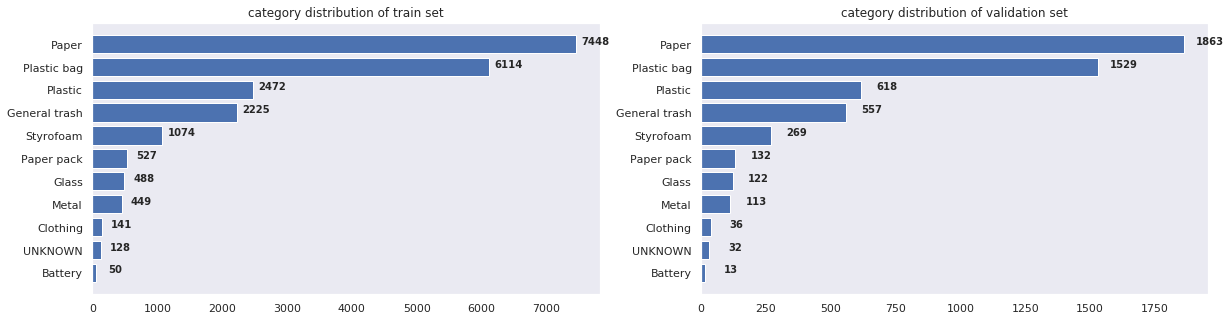

In [4]:
# Initialize the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(20,5))

# Count annotations
train_cat_histogram = np.zeros(len(train_categories), dtype=int)
for ann in train_anns:
    train_cat_histogram[ann['category_id']] += 1

val_cat_histogram = np.zeros(len(val_categories), dtype=int)
for ann in val_anns:
    val_cat_histogram[ann['category_id']] += 1

# Convert to DataFrame
train_df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': train_cat_histogram})
train_df = train_df.sort_values('Number of annotations', axis=0, ascending=True)

val_df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': val_cat_histogram})
val_df = val_df.sort_values('Number of annotations', axis=0, ascending=True)

# Plot the histogram
axes[0].set_title("category distribution of train set")
axes[0].barh(train_df['Categories'], train_df['Number of annotations'])

axes[1].set_title("category distribution of validation set")
axes[1].barh(val_df['Categories'], val_df['Number of annotations'])

for idx, value in enumerate(train_df['Number of annotations'].values):
    axes[0].text(value+300, idx, s=value, ha='center', fontweight='bold')
for idx, value in enumerate(val_df['Number of annotations'].values):
    axes[1].text(value+100, idx, s=value, ha='center', fontweight='bold')

## Dataset Images Statistics

In [5]:
def get_img_stats(image_paths):
    """
    데이터셋에 있는 이미지들의 크기와 RGB 평균 및 표준편차를 수집하는 함수입니다.
    
    Args:
        image_paths: 학습 데이터셋 이미지 경로 

    Returns:
        img_info: 이미지들의 정보 (크기, 평균, 표준편차)
    """
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for image_path in tqdm(image_paths):
        img = np.array(Image.open(image_path))
        h, w, _ = img.shape
        img_info['heights'].append(h)
        img_info['widths'].append(w)
        img_info['means'].append(img.mean(axis=(0,1)))
        img_info['stds'].append(img.std(axis=(0,1)))
        
    return img_info

In [6]:
# train_all.json
all_anns_file_path = dataset_path + '/' + 'train_all.json'

# Read annotations
with open(all_anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

all_imgs = dataset['images']

img_paths = []
for img in all_imgs:
    img_paths.append(dataset_path + '/' + img['file_name'])

In [7]:
img_info = get_img_stats(img_paths)

print(f'Total number of imgage is {len(img_paths)}')

print(f'Minimum height for dataset is {np.min(img_info["heights"])}')
print(f'Maximum height for dataset is {np.max(img_info["heights"])}')
print(f'Average height for dataset is {np.mean(img_info["heights"])}')
print(f'Minimum width for dataset is {np.min(img_info["widths"])}')
print(f'Maximum width for dataset is {np.max(img_info["widths"])}')
print(f'Average width for dataset is {np.mean(img_info["widths"])}')

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')



100%|██████████| 3272/3272 [01:55<00:00, 28.29it/s]Total number of imgage is 3272
Minimum height for dataset is 512
Maximum height for dataset is 512
Average height for dataset is 512.0
Minimum width for dataset is 512
Maximum width for dataset is 512
Average width for dataset is 512.0
RGB Mean: [0.46009655 0.43957878 0.41827092]
RGB Standard Deviation: [0.2108204  0.20766491 0.21656131]

